# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

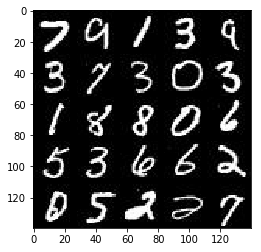

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

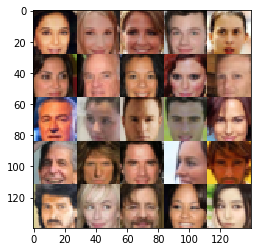

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    tf.maximum(x, alpha * x, name=name)
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #relu1 = leaky_relu(x1, alpha=0.01)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #relu2 = leaky_relu(bn2, alpha=0.01)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #relu3 = leaky_relu(bn3, alpha=0.01)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        h1 = tf.layers.dense(z, out_channel_dim, activation=None)
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = leaky_relu(x1, alpha=0.01)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # x2 = leaky_relu(x2, alpha = 0.01)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = leaky_relu(x3, alpha = 0.01)
        x3 = tf.maximum(alpha*x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generator network here
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # g_model is the generator output

    # Disriminator network here
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                        labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_logits_real)))
    
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """ 
    #model_inputs(image_width, image_height, image_channels, z_dim):
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                i += 1
                # TODO: Train Model
                batch_images = batch_images * 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                
                if i % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                if i % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, i, data_shape[0]//batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)


(60000, 28, 28, 1)


Epoch 1/2 - Batch 10/1875:  Discriminator Loss: 0.5990... Generator Loss: 1.6862
Epoch 1/2 - Batch 20/1875:  Discriminator Loss: 0.6930... Generator Loss: 1.3685
Epoch 1/2 - Batch 30/1875:  Discriminator Loss: 0.4196... Generator Loss: 3.4450
Epoch 1/2 - Batch 40/1875:  Discriminator Loss: 0.9873... Generator Loss: 5.6491
Epoch 1/2 - Batch 50/1875:  Discriminator Loss: 0.5558... Generator Loss: 2.4152
Epoch 1/2 - Batch 60/1875:  Discriminator Loss: 0.5234... Generator Loss: 2.1148
Epoch 1/2 - Batch 70/1875:  Discriminator Loss: 0.5636... Generator Loss: 2.2327
Epoch 1/2 - Batch 80/1875:  Discriminator Loss: 0.5782... Generator Loss: 1.8278
Epoch 1/2 - Batch 90/1875:  Discriminator Loss: 0.3935... Generator Loss: 3.5792


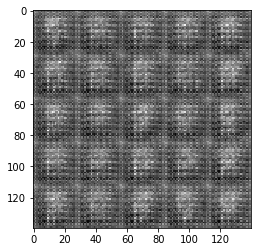

Epoch 1/2 - Batch 100/1875:  Discriminator Loss: 0.4271... Generator Loss: 3.0099
Epoch 1/2 - Batch 110/1875:  Discriminator Loss: 0.5408... Generator Loss: 1.9890
Epoch 1/2 - Batch 120/1875:  Discriminator Loss: 0.3970... Generator Loss: 3.6348
Epoch 1/2 - Batch 130/1875:  Discriminator Loss: 0.4568... Generator Loss: 2.8138
Epoch 1/2 - Batch 140/1875:  Discriminator Loss: 0.9601... Generator Loss: 0.9396
Epoch 1/2 - Batch 150/1875:  Discriminator Loss: 0.8483... Generator Loss: 2.0073
Epoch 1/2 - Batch 160/1875:  Discriminator Loss: 0.7568... Generator Loss: 1.9549
Epoch 1/2 - Batch 170/1875:  Discriminator Loss: 0.5351... Generator Loss: 2.6505
Epoch 1/2 - Batch 180/1875:  Discriminator Loss: 0.5772... Generator Loss: 2.3955
Epoch 1/2 - Batch 190/1875:  Discriminator Loss: 0.6315... Generator Loss: 1.8354


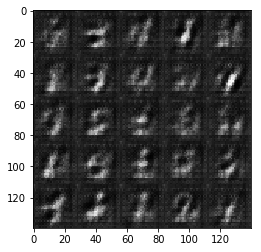

Epoch 1/2 - Batch 200/1875:  Discriminator Loss: 1.3884... Generator Loss: 0.5738
Epoch 1/2 - Batch 210/1875:  Discriminator Loss: 0.6503... Generator Loss: 1.6113
Epoch 1/2 - Batch 220/1875:  Discriminator Loss: 0.6096... Generator Loss: 1.7960
Epoch 1/2 - Batch 230/1875:  Discriminator Loss: 0.8438... Generator Loss: 1.1301
Epoch 1/2 - Batch 240/1875:  Discriminator Loss: 0.8084... Generator Loss: 2.5304
Epoch 1/2 - Batch 250/1875:  Discriminator Loss: 0.8114... Generator Loss: 1.2177
Epoch 1/2 - Batch 260/1875:  Discriminator Loss: 0.6966... Generator Loss: 1.9268
Epoch 1/2 - Batch 270/1875:  Discriminator Loss: 0.8173... Generator Loss: 1.6169
Epoch 1/2 - Batch 280/1875:  Discriminator Loss: 0.6898... Generator Loss: 2.7334
Epoch 1/2 - Batch 290/1875:  Discriminator Loss: 0.9141... Generator Loss: 2.7818


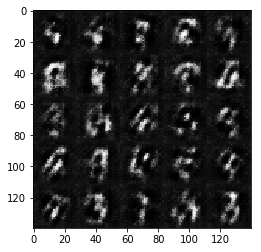

Epoch 1/2 - Batch 300/1875:  Discriminator Loss: 0.6305... Generator Loss: 1.7269
Epoch 1/2 - Batch 310/1875:  Discriminator Loss: 0.9292... Generator Loss: 0.9323
Epoch 1/2 - Batch 320/1875:  Discriminator Loss: 0.6868... Generator Loss: 1.7104
Epoch 1/2 - Batch 330/1875:  Discriminator Loss: 0.8770... Generator Loss: 0.9840
Epoch 1/2 - Batch 340/1875:  Discriminator Loss: 0.6614... Generator Loss: 1.7382
Epoch 1/2 - Batch 350/1875:  Discriminator Loss: 0.6356... Generator Loss: 1.6437
Epoch 1/2 - Batch 360/1875:  Discriminator Loss: 1.0357... Generator Loss: 0.8971
Epoch 1/2 - Batch 370/1875:  Discriminator Loss: 0.8161... Generator Loss: 2.9680
Epoch 1/2 - Batch 380/1875:  Discriminator Loss: 0.7085... Generator Loss: 2.6622
Epoch 1/2 - Batch 390/1875:  Discriminator Loss: 0.8362... Generator Loss: 1.1332


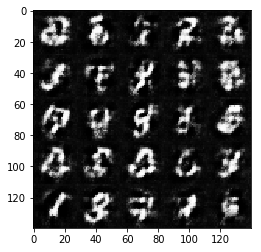

Epoch 1/2 - Batch 400/1875:  Discriminator Loss: 0.6804... Generator Loss: 1.4845
Epoch 1/2 - Batch 410/1875:  Discriminator Loss: 0.8066... Generator Loss: 2.1950
Epoch 1/2 - Batch 420/1875:  Discriminator Loss: 0.6898... Generator Loss: 1.8853
Epoch 1/2 - Batch 430/1875:  Discriminator Loss: 1.0121... Generator Loss: 3.4776
Epoch 1/2 - Batch 440/1875:  Discriminator Loss: 0.7922... Generator Loss: 2.3907
Epoch 1/2 - Batch 450/1875:  Discriminator Loss: 0.7967... Generator Loss: 2.5843
Epoch 1/2 - Batch 460/1875:  Discriminator Loss: 0.6344... Generator Loss: 2.2900
Epoch 1/2 - Batch 470/1875:  Discriminator Loss: 0.8488... Generator Loss: 1.0367
Epoch 1/2 - Batch 480/1875:  Discriminator Loss: 0.6831... Generator Loss: 2.5980
Epoch 1/2 - Batch 490/1875:  Discriminator Loss: 0.6057... Generator Loss: 1.9207


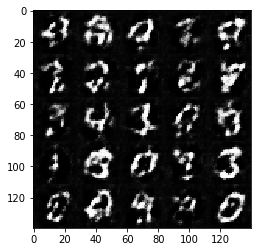

Epoch 1/2 - Batch 500/1875:  Discriminator Loss: 0.6007... Generator Loss: 1.8693
Epoch 1/2 - Batch 510/1875:  Discriminator Loss: 0.5668... Generator Loss: 2.2707
Epoch 1/2 - Batch 520/1875:  Discriminator Loss: 0.6200... Generator Loss: 2.0005
Epoch 1/2 - Batch 530/1875:  Discriminator Loss: 1.0027... Generator Loss: 0.9356
Epoch 1/2 - Batch 540/1875:  Discriminator Loss: 0.5583... Generator Loss: 2.0755
Epoch 1/2 - Batch 550/1875:  Discriminator Loss: 0.6553... Generator Loss: 1.5503
Epoch 1/2 - Batch 560/1875:  Discriminator Loss: 1.2968... Generator Loss: 4.3565
Epoch 1/2 - Batch 570/1875:  Discriminator Loss: 0.6686... Generator Loss: 1.5990
Epoch 1/2 - Batch 580/1875:  Discriminator Loss: 0.6567... Generator Loss: 1.9860
Epoch 1/2 - Batch 590/1875:  Discriminator Loss: 0.5715... Generator Loss: 1.9747


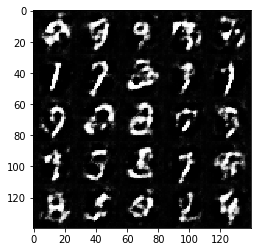

Epoch 1/2 - Batch 600/1875:  Discriminator Loss: 0.6132... Generator Loss: 1.9263
Epoch 1/2 - Batch 610/1875:  Discriminator Loss: 0.5762... Generator Loss: 2.4884
Epoch 1/2 - Batch 620/1875:  Discriminator Loss: 0.6226... Generator Loss: 2.2792
Epoch 1/2 - Batch 630/1875:  Discriminator Loss: 0.6111... Generator Loss: 2.5587
Epoch 1/2 - Batch 640/1875:  Discriminator Loss: 1.0322... Generator Loss: 3.7031
Epoch 1/2 - Batch 650/1875:  Discriminator Loss: 0.6347... Generator Loss: 1.5650
Epoch 1/2 - Batch 660/1875:  Discriminator Loss: 1.1661... Generator Loss: 0.7276
Epoch 1/2 - Batch 670/1875:  Discriminator Loss: 0.6603... Generator Loss: 1.6236
Epoch 1/2 - Batch 680/1875:  Discriminator Loss: 0.6783... Generator Loss: 1.5284
Epoch 1/2 - Batch 690/1875:  Discriminator Loss: 0.6710... Generator Loss: 2.3282


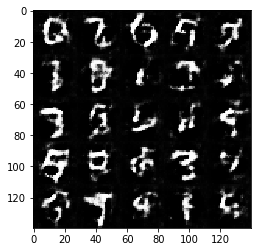

Epoch 1/2 - Batch 700/1875:  Discriminator Loss: 0.8700... Generator Loss: 2.9995
Epoch 1/2 - Batch 710/1875:  Discriminator Loss: 0.5867... Generator Loss: 2.1751
Epoch 1/2 - Batch 720/1875:  Discriminator Loss: 0.9260... Generator Loss: 0.9152
Epoch 1/2 - Batch 730/1875:  Discriminator Loss: 1.1189... Generator Loss: 3.5944
Epoch 1/2 - Batch 740/1875:  Discriminator Loss: 0.6214... Generator Loss: 1.8920
Epoch 1/2 - Batch 750/1875:  Discriminator Loss: 0.6956... Generator Loss: 1.5280
Epoch 1/2 - Batch 760/1875:  Discriminator Loss: 0.8121... Generator Loss: 1.1480
Epoch 1/2 - Batch 770/1875:  Discriminator Loss: 0.5805... Generator Loss: 2.1357
Epoch 1/2 - Batch 780/1875:  Discriminator Loss: 1.1187... Generator Loss: 0.7327
Epoch 1/2 - Batch 790/1875:  Discriminator Loss: 0.7635... Generator Loss: 1.3137


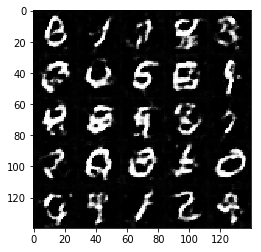

Epoch 1/2 - Batch 800/1875:  Discriminator Loss: 1.1311... Generator Loss: 0.7102
Epoch 1/2 - Batch 810/1875:  Discriminator Loss: 0.7062... Generator Loss: 1.4340
Epoch 1/2 - Batch 820/1875:  Discriminator Loss: 0.5868... Generator Loss: 1.8789
Epoch 1/2 - Batch 830/1875:  Discriminator Loss: 0.7636... Generator Loss: 1.2314
Epoch 1/2 - Batch 840/1875:  Discriminator Loss: 0.8886... Generator Loss: 1.0158
Epoch 1/2 - Batch 850/1875:  Discriminator Loss: 0.6002... Generator Loss: 1.7901
Epoch 1/2 - Batch 860/1875:  Discriminator Loss: 1.2194... Generator Loss: 0.6656
Epoch 1/2 - Batch 870/1875:  Discriminator Loss: 0.6599... Generator Loss: 2.3506
Epoch 1/2 - Batch 880/1875:  Discriminator Loss: 0.6466... Generator Loss: 2.2143
Epoch 1/2 - Batch 890/1875:  Discriminator Loss: 0.5838... Generator Loss: 2.6118


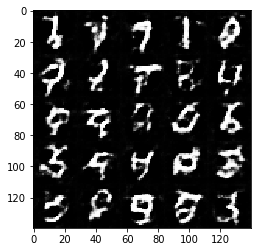

Epoch 1/2 - Batch 900/1875:  Discriminator Loss: 0.7566... Generator Loss: 1.2197
Epoch 1/2 - Batch 910/1875:  Discriminator Loss: 0.6002... Generator Loss: 1.9253
Epoch 1/2 - Batch 920/1875:  Discriminator Loss: 0.5806... Generator Loss: 1.8001
Epoch 1/2 - Batch 930/1875:  Discriminator Loss: 0.9795... Generator Loss: 1.0511
Epoch 1/2 - Batch 940/1875:  Discriminator Loss: 0.8218... Generator Loss: 1.1332
Epoch 1/2 - Batch 950/1875:  Discriminator Loss: 0.6643... Generator Loss: 1.9821
Epoch 1/2 - Batch 960/1875:  Discriminator Loss: 0.6320... Generator Loss: 2.1985
Epoch 1/2 - Batch 970/1875:  Discriminator Loss: 1.0502... Generator Loss: 0.7813
Epoch 1/2 - Batch 980/1875:  Discriminator Loss: 0.9048... Generator Loss: 0.9969
Epoch 1/2 - Batch 990/1875:  Discriminator Loss: 1.0934... Generator Loss: 0.8026


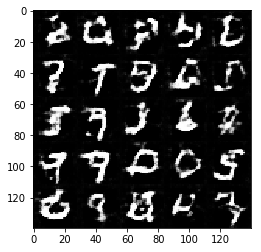

Epoch 1/2 - Batch 1000/1875:  Discriminator Loss: 0.9956... Generator Loss: 0.8389
Epoch 1/2 - Batch 1010/1875:  Discriminator Loss: 0.5220... Generator Loss: 2.3444
Epoch 1/2 - Batch 1020/1875:  Discriminator Loss: 0.8248... Generator Loss: 1.1250
Epoch 1/2 - Batch 1030/1875:  Discriminator Loss: 0.6643... Generator Loss: 1.5346
Epoch 1/2 - Batch 1040/1875:  Discriminator Loss: 0.8082... Generator Loss: 1.5547
Epoch 1/2 - Batch 1050/1875:  Discriminator Loss: 0.7680... Generator Loss: 1.2245
Epoch 1/2 - Batch 1060/1875:  Discriminator Loss: 0.6097... Generator Loss: 1.8024
Epoch 1/2 - Batch 1070/1875:  Discriminator Loss: 0.6236... Generator Loss: 1.5477
Epoch 1/2 - Batch 1080/1875:  Discriminator Loss: 0.6460... Generator Loss: 1.5167
Epoch 1/2 - Batch 1090/1875:  Discriminator Loss: 1.2774... Generator Loss: 0.6449


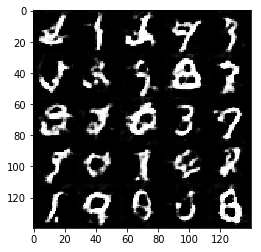

Epoch 1/2 - Batch 1100/1875:  Discriminator Loss: 0.7635... Generator Loss: 1.2171
Epoch 1/2 - Batch 1110/1875:  Discriminator Loss: 1.4107... Generator Loss: 0.6702
Epoch 1/2 - Batch 1120/1875:  Discriminator Loss: 0.6200... Generator Loss: 1.7917
Epoch 1/2 - Batch 1130/1875:  Discriminator Loss: 0.8138... Generator Loss: 1.1599
Epoch 1/2 - Batch 1140/1875:  Discriminator Loss: 0.7540... Generator Loss: 1.3575
Epoch 1/2 - Batch 1150/1875:  Discriminator Loss: 0.6461... Generator Loss: 1.9682
Epoch 1/2 - Batch 1160/1875:  Discriminator Loss: 0.9363... Generator Loss: 1.0288
Epoch 1/2 - Batch 1170/1875:  Discriminator Loss: 0.6242... Generator Loss: 1.8740
Epoch 1/2 - Batch 1180/1875:  Discriminator Loss: 0.6318... Generator Loss: 1.7343
Epoch 1/2 - Batch 1190/1875:  Discriminator Loss: 0.6241... Generator Loss: 1.6400


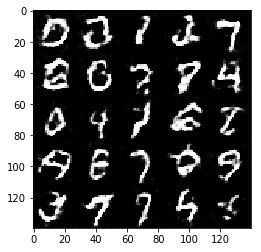

Epoch 1/2 - Batch 1200/1875:  Discriminator Loss: 0.6734... Generator Loss: 1.4058
Epoch 1/2 - Batch 1210/1875:  Discriminator Loss: 0.8426... Generator Loss: 1.0514
Epoch 1/2 - Batch 1220/1875:  Discriminator Loss: 0.7393... Generator Loss: 1.2670
Epoch 1/2 - Batch 1230/1875:  Discriminator Loss: 0.6837... Generator Loss: 1.4342
Epoch 1/2 - Batch 1240/1875:  Discriminator Loss: 0.6005... Generator Loss: 1.9550
Epoch 1/2 - Batch 1250/1875:  Discriminator Loss: 0.9178... Generator Loss: 0.9472
Epoch 1/2 - Batch 1260/1875:  Discriminator Loss: 0.8392... Generator Loss: 1.0507
Epoch 1/2 - Batch 1270/1875:  Discriminator Loss: 4.2084... Generator Loss: 0.0481
Epoch 1/2 - Batch 1280/1875:  Discriminator Loss: 0.5743... Generator Loss: 1.8532
Epoch 1/2 - Batch 1290/1875:  Discriminator Loss: 0.7799... Generator Loss: 1.1961


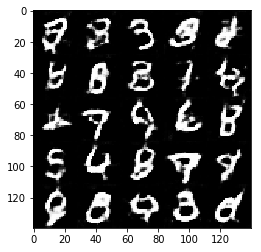

Epoch 1/2 - Batch 1300/1875:  Discriminator Loss: 0.6020... Generator Loss: 2.3817
Epoch 1/2 - Batch 1310/1875:  Discriminator Loss: 0.9088... Generator Loss: 1.0607
Epoch 1/2 - Batch 1320/1875:  Discriminator Loss: 0.7162... Generator Loss: 1.3723
Epoch 1/2 - Batch 1330/1875:  Discriminator Loss: 0.7489... Generator Loss: 1.2744
Epoch 1/2 - Batch 1340/1875:  Discriminator Loss: 0.7299... Generator Loss: 1.2286
Epoch 1/2 - Batch 1350/1875:  Discriminator Loss: 2.6824... Generator Loss: 5.5082
Epoch 1/2 - Batch 1360/1875:  Discriminator Loss: 0.9243... Generator Loss: 1.6400
Epoch 1/2 - Batch 1370/1875:  Discriminator Loss: 0.7085... Generator Loss: 1.8679
Epoch 1/2 - Batch 1380/1875:  Discriminator Loss: 0.6546... Generator Loss: 1.7143
Epoch 1/2 - Batch 1390/1875:  Discriminator Loss: 0.8258... Generator Loss: 1.0789


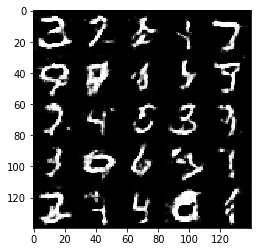

Epoch 1/2 - Batch 1400/1875:  Discriminator Loss: 0.7166... Generator Loss: 1.4151
Epoch 1/2 - Batch 1410/1875:  Discriminator Loss: 0.5340... Generator Loss: 2.0876
Epoch 1/2 - Batch 1420/1875:  Discriminator Loss: 0.6057... Generator Loss: 2.4808
Epoch 1/2 - Batch 1430/1875:  Discriminator Loss: 0.5731... Generator Loss: 1.8338
Epoch 1/2 - Batch 1440/1875:  Discriminator Loss: 0.7153... Generator Loss: 1.3647
Epoch 1/2 - Batch 1450/1875:  Discriminator Loss: 0.5314... Generator Loss: 1.8869
Epoch 1/2 - Batch 1460/1875:  Discriminator Loss: 0.6500... Generator Loss: 1.5354
Epoch 1/2 - Batch 1470/1875:  Discriminator Loss: 0.6651... Generator Loss: 1.4560
Epoch 1/2 - Batch 1480/1875:  Discriminator Loss: 0.8039... Generator Loss: 1.1112
Epoch 1/2 - Batch 1490/1875:  Discriminator Loss: 1.2389... Generator Loss: 0.8143


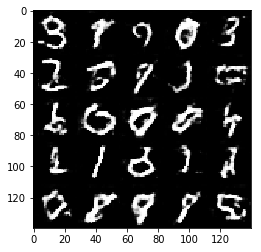

Epoch 1/2 - Batch 1500/1875:  Discriminator Loss: 0.5826... Generator Loss: 1.8351
Epoch 1/2 - Batch 1510/1875:  Discriminator Loss: 0.7200... Generator Loss: 1.3949
Epoch 1/2 - Batch 1520/1875:  Discriminator Loss: 0.6082... Generator Loss: 1.7254
Epoch 1/2 - Batch 1530/1875:  Discriminator Loss: 0.6386... Generator Loss: 1.6259
Epoch 1/2 - Batch 1540/1875:  Discriminator Loss: 0.6028... Generator Loss: 1.5860
Epoch 1/2 - Batch 1550/1875:  Discriminator Loss: 0.6868... Generator Loss: 1.3482
Epoch 1/2 - Batch 1560/1875:  Discriminator Loss: 0.5535... Generator Loss: 2.0215
Epoch 1/2 - Batch 1570/1875:  Discriminator Loss: 0.5429... Generator Loss: 2.2537
Epoch 1/2 - Batch 1580/1875:  Discriminator Loss: 0.6062... Generator Loss: 1.6703
Epoch 1/2 - Batch 1590/1875:  Discriminator Loss: 0.6637... Generator Loss: 1.4530


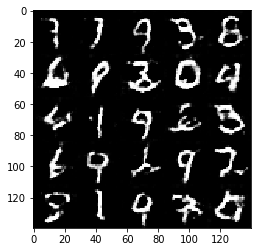

Epoch 1/2 - Batch 1600/1875:  Discriminator Loss: 0.7063... Generator Loss: 1.3699
Epoch 1/2 - Batch 1610/1875:  Discriminator Loss: 0.9307... Generator Loss: 1.7375
Epoch 1/2 - Batch 1620/1875:  Discriminator Loss: 0.4865... Generator Loss: 2.4604
Epoch 1/2 - Batch 1630/1875:  Discriminator Loss: 0.4904... Generator Loss: 2.5947
Epoch 1/2 - Batch 1640/1875:  Discriminator Loss: 0.6810... Generator Loss: 1.5678
Epoch 1/2 - Batch 1650/1875:  Discriminator Loss: 0.5246... Generator Loss: 2.2863
Epoch 1/2 - Batch 1660/1875:  Discriminator Loss: 0.7004... Generator Loss: 1.4444
Epoch 1/2 - Batch 1670/1875:  Discriminator Loss: 0.6563... Generator Loss: 1.6393
Epoch 1/2 - Batch 1680/1875:  Discriminator Loss: 0.6338... Generator Loss: 1.4525
Epoch 1/2 - Batch 1690/1875:  Discriminator Loss: 1.4153... Generator Loss: 0.7970


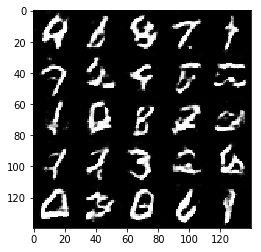

Epoch 1/2 - Batch 1700/1875:  Discriminator Loss: 0.6121... Generator Loss: 2.1068
Epoch 1/2 - Batch 1710/1875:  Discriminator Loss: 0.6335... Generator Loss: 1.5089
Epoch 1/2 - Batch 1720/1875:  Discriminator Loss: 0.5745... Generator Loss: 1.8276
Epoch 1/2 - Batch 1730/1875:  Discriminator Loss: 0.6463... Generator Loss: 1.4597
Epoch 1/2 - Batch 1740/1875:  Discriminator Loss: 0.7945... Generator Loss: 1.1284
Epoch 1/2 - Batch 1750/1875:  Discriminator Loss: 0.6608... Generator Loss: 1.7787
Epoch 1/2 - Batch 1760/1875:  Discriminator Loss: 0.8102... Generator Loss: 1.7669
Epoch 1/2 - Batch 1770/1875:  Discriminator Loss: 0.6061... Generator Loss: 2.0352
Epoch 1/2 - Batch 1780/1875:  Discriminator Loss: 0.7175... Generator Loss: 1.3419
Epoch 1/2 - Batch 1790/1875:  Discriminator Loss: 0.6986... Generator Loss: 1.3464


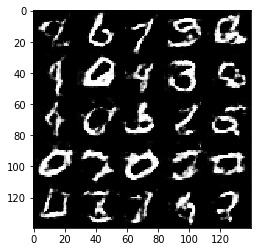

Epoch 1/2 - Batch 1800/1875:  Discriminator Loss: 0.5842... Generator Loss: 1.7831
Epoch 1/2 - Batch 1810/1875:  Discriminator Loss: 0.5933... Generator Loss: 2.4100
Epoch 1/2 - Batch 1820/1875:  Discriminator Loss: 0.7411... Generator Loss: 1.2084
Epoch 1/2 - Batch 1830/1875:  Discriminator Loss: 0.7576... Generator Loss: 1.1384
Epoch 1/2 - Batch 1840/1875:  Discriminator Loss: 0.7369... Generator Loss: 1.3103
Epoch 1/2 - Batch 1850/1875:  Discriminator Loss: 0.6049... Generator Loss: 1.9868
Epoch 1/2 - Batch 1860/1875:  Discriminator Loss: 0.5870... Generator Loss: 1.6568
Epoch 1/2 - Batch 1870/1875:  Discriminator Loss: 0.7342... Generator Loss: 1.2367
Epoch 2/2 - Batch 10/1875:  Discriminator Loss: 0.5844... Generator Loss: 1.6685
Epoch 2/2 - Batch 20/1875:  Discriminator Loss: 0.4976... Generator Loss: 2.2670
Epoch 2/2 - Batch 30/1875:  Discriminator Loss: 0.7295... Generator Loss: 1.2608
Epoch 2/2 - Batch 40/1875:  Discriminator Loss: 0.6079... Generator Loss: 1.9946
Epoch 2/2 - 

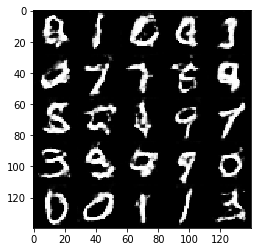

Epoch 2/2 - Batch 100/1875:  Discriminator Loss: 0.7139... Generator Loss: 1.2924
Epoch 2/2 - Batch 110/1875:  Discriminator Loss: 0.6692... Generator Loss: 1.4138
Epoch 2/2 - Batch 120/1875:  Discriminator Loss: 0.5195... Generator Loss: 2.0727
Epoch 2/2 - Batch 130/1875:  Discriminator Loss: 0.5602... Generator Loss: 1.8437
Epoch 2/2 - Batch 140/1875:  Discriminator Loss: 0.6431... Generator Loss: 1.6843
Epoch 2/2 - Batch 150/1875:  Discriminator Loss: 0.5321... Generator Loss: 2.2161
Epoch 2/2 - Batch 160/1875:  Discriminator Loss: 0.7121... Generator Loss: 1.3569
Epoch 2/2 - Batch 170/1875:  Discriminator Loss: 0.6694... Generator Loss: 1.7129
Epoch 2/2 - Batch 180/1875:  Discriminator Loss: 0.9623... Generator Loss: 1.8513
Epoch 2/2 - Batch 190/1875:  Discriminator Loss: 0.7708... Generator Loss: 1.3818


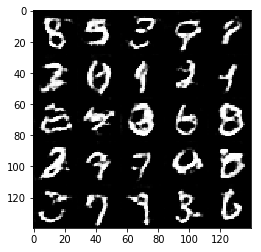

Epoch 2/2 - Batch 200/1875:  Discriminator Loss: 0.8102... Generator Loss: 1.2100
Epoch 2/2 - Batch 210/1875:  Discriminator Loss: 0.8256... Generator Loss: 1.0330
Epoch 2/2 - Batch 220/1875:  Discriminator Loss: 0.5995... Generator Loss: 1.7451
Epoch 2/2 - Batch 230/1875:  Discriminator Loss: 0.6687... Generator Loss: 1.5701
Epoch 2/2 - Batch 240/1875:  Discriminator Loss: 0.7158... Generator Loss: 1.3702
Epoch 2/2 - Batch 250/1875:  Discriminator Loss: 0.6786... Generator Loss: 1.3952
Epoch 2/2 - Batch 260/1875:  Discriminator Loss: 0.9021... Generator Loss: 0.9570
Epoch 2/2 - Batch 270/1875:  Discriminator Loss: 0.7670... Generator Loss: 1.2309
Epoch 2/2 - Batch 280/1875:  Discriminator Loss: 0.5883... Generator Loss: 1.7897
Epoch 2/2 - Batch 290/1875:  Discriminator Loss: 0.8814... Generator Loss: 1.0211


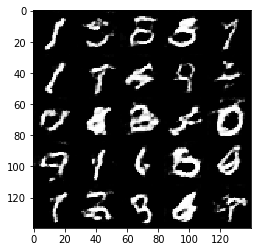

Epoch 2/2 - Batch 300/1875:  Discriminator Loss: 0.4886... Generator Loss: 2.1466
Epoch 2/2 - Batch 310/1875:  Discriminator Loss: 0.7167... Generator Loss: 1.2808
Epoch 2/2 - Batch 320/1875:  Discriminator Loss: 0.9289... Generator Loss: 0.9283
Epoch 2/2 - Batch 330/1875:  Discriminator Loss: 0.7127... Generator Loss: 1.4046
Epoch 2/2 - Batch 340/1875:  Discriminator Loss: 0.6752... Generator Loss: 1.3828
Epoch 2/2 - Batch 350/1875:  Discriminator Loss: 0.5861... Generator Loss: 1.7812
Epoch 2/2 - Batch 360/1875:  Discriminator Loss: 0.6252... Generator Loss: 1.6326
Epoch 2/2 - Batch 370/1875:  Discriminator Loss: 0.5388... Generator Loss: 1.9210
Epoch 2/2 - Batch 380/1875:  Discriminator Loss: 0.6319... Generator Loss: 1.5446
Epoch 2/2 - Batch 390/1875:  Discriminator Loss: 0.5342... Generator Loss: 1.8741


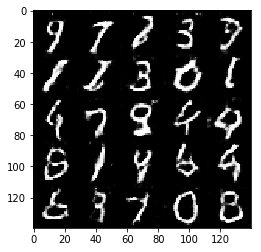

Epoch 2/2 - Batch 400/1875:  Discriminator Loss: 2.2118... Generator Loss: 4.2651
Epoch 2/2 - Batch 410/1875:  Discriminator Loss: 0.6489... Generator Loss: 1.7761
Epoch 2/2 - Batch 420/1875:  Discriminator Loss: 0.9233... Generator Loss: 1.0060
Epoch 2/2 - Batch 430/1875:  Discriminator Loss: 0.5980... Generator Loss: 2.4517
Epoch 2/2 - Batch 440/1875:  Discriminator Loss: 0.5558... Generator Loss: 1.8378
Epoch 2/2 - Batch 450/1875:  Discriminator Loss: 0.7242... Generator Loss: 1.2212
Epoch 2/2 - Batch 460/1875:  Discriminator Loss: 0.6360... Generator Loss: 1.6454
Epoch 2/2 - Batch 470/1875:  Discriminator Loss: 1.3241... Generator Loss: 0.7026
Epoch 2/2 - Batch 480/1875:  Discriminator Loss: 0.7038... Generator Loss: 1.4901
Epoch 2/2 - Batch 490/1875:  Discriminator Loss: 0.7741... Generator Loss: 1.1857


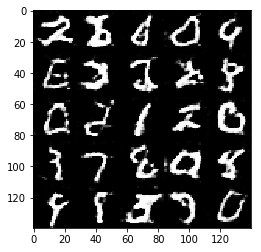

Epoch 2/2 - Batch 500/1875:  Discriminator Loss: 0.8519... Generator Loss: 1.0426
Epoch 2/2 - Batch 510/1875:  Discriminator Loss: 0.5446... Generator Loss: 1.8968
Epoch 2/2 - Batch 520/1875:  Discriminator Loss: 0.6261... Generator Loss: 1.5996
Epoch 2/2 - Batch 530/1875:  Discriminator Loss: 0.6631... Generator Loss: 1.4281
Epoch 2/2 - Batch 540/1875:  Discriminator Loss: 0.7650... Generator Loss: 1.1413
Epoch 2/2 - Batch 550/1875:  Discriminator Loss: 0.6372... Generator Loss: 1.5915
Epoch 2/2 - Batch 560/1875:  Discriminator Loss: 0.5958... Generator Loss: 2.6320
Epoch 2/2 - Batch 570/1875:  Discriminator Loss: 0.6518... Generator Loss: 1.4292
Epoch 2/2 - Batch 580/1875:  Discriminator Loss: 0.5579... Generator Loss: 2.3338
Epoch 2/2 - Batch 590/1875:  Discriminator Loss: 0.6416... Generator Loss: 1.5944


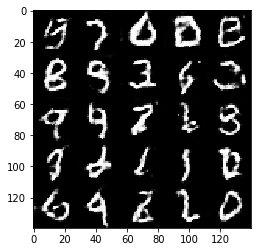

Epoch 2/2 - Batch 600/1875:  Discriminator Loss: 0.5495... Generator Loss: 1.9523
Epoch 2/2 - Batch 610/1875:  Discriminator Loss: 0.5093... Generator Loss: 2.0869
Epoch 2/2 - Batch 620/1875:  Discriminator Loss: 0.9588... Generator Loss: 0.9307
Epoch 2/2 - Batch 630/1875:  Discriminator Loss: 0.5334... Generator Loss: 2.0801
Epoch 2/2 - Batch 640/1875:  Discriminator Loss: 0.7518... Generator Loss: 1.2253
Epoch 2/2 - Batch 650/1875:  Discriminator Loss: 0.5518... Generator Loss: 1.8505
Epoch 2/2 - Batch 660/1875:  Discriminator Loss: 0.5650... Generator Loss: 1.7660
Epoch 2/2 - Batch 670/1875:  Discriminator Loss: 0.6378... Generator Loss: 1.5913
Epoch 2/2 - Batch 680/1875:  Discriminator Loss: 0.4804... Generator Loss: 2.5832
Epoch 2/2 - Batch 690/1875:  Discriminator Loss: 0.6046... Generator Loss: 1.6585


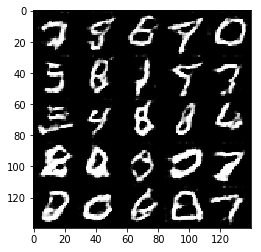

Epoch 2/2 - Batch 700/1875:  Discriminator Loss: 0.6136... Generator Loss: 2.1151
Epoch 2/2 - Batch 710/1875:  Discriminator Loss: 0.5252... Generator Loss: 2.6332
Epoch 2/2 - Batch 720/1875:  Discriminator Loss: 1.5135... Generator Loss: 0.6090
Epoch 2/2 - Batch 730/1875:  Discriminator Loss: 0.5906... Generator Loss: 1.8226
Epoch 2/2 - Batch 740/1875:  Discriminator Loss: 0.6763... Generator Loss: 1.3967
Epoch 2/2 - Batch 750/1875:  Discriminator Loss: 0.4867... Generator Loss: 2.4318
Epoch 2/2 - Batch 760/1875:  Discriminator Loss: 0.6223... Generator Loss: 1.6415
Epoch 2/2 - Batch 770/1875:  Discriminator Loss: 0.5629... Generator Loss: 1.8201
Epoch 2/2 - Batch 780/1875:  Discriminator Loss: 1.2032... Generator Loss: 0.8236
Epoch 2/2 - Batch 790/1875:  Discriminator Loss: 0.7816... Generator Loss: 1.3197


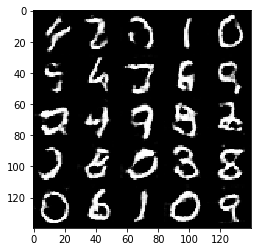

Epoch 2/2 - Batch 800/1875:  Discriminator Loss: 0.7041... Generator Loss: 1.3388
Epoch 2/2 - Batch 810/1875:  Discriminator Loss: 1.2063... Generator Loss: 0.6844
Epoch 2/2 - Batch 820/1875:  Discriminator Loss: 0.5904... Generator Loss: 1.7163
Epoch 2/2 - Batch 830/1875:  Discriminator Loss: 0.7195... Generator Loss: 1.3687
Epoch 2/2 - Batch 840/1875:  Discriminator Loss: 0.7226... Generator Loss: 1.2710
Epoch 2/2 - Batch 850/1875:  Discriminator Loss: 0.4699... Generator Loss: 2.4395
Epoch 2/2 - Batch 860/1875:  Discriminator Loss: 0.6584... Generator Loss: 1.5454
Epoch 2/2 - Batch 870/1875:  Discriminator Loss: 0.5421... Generator Loss: 2.0153
Epoch 2/2 - Batch 880/1875:  Discriminator Loss: 0.6095... Generator Loss: 1.6725
Epoch 2/2 - Batch 890/1875:  Discriminator Loss: 2.3798... Generator Loss: 0.3281


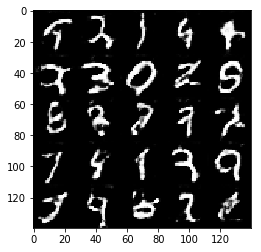

Epoch 2/2 - Batch 900/1875:  Discriminator Loss: 0.6415... Generator Loss: 1.6489
Epoch 2/2 - Batch 910/1875:  Discriminator Loss: 0.5989... Generator Loss: 1.7127
Epoch 2/2 - Batch 920/1875:  Discriminator Loss: 0.5542... Generator Loss: 1.7917
Epoch 2/2 - Batch 930/1875:  Discriminator Loss: 0.8154... Generator Loss: 1.1138
Epoch 2/2 - Batch 940/1875:  Discriminator Loss: 0.6873... Generator Loss: 1.4675
Epoch 2/2 - Batch 950/1875:  Discriminator Loss: 1.2753... Generator Loss: 0.6532
Epoch 2/2 - Batch 960/1875:  Discriminator Loss: 0.6593... Generator Loss: 1.6251
Epoch 2/2 - Batch 970/1875:  Discriminator Loss: 0.6786... Generator Loss: 1.3950
Epoch 2/2 - Batch 980/1875:  Discriminator Loss: 0.6793... Generator Loss: 1.4471
Epoch 2/2 - Batch 990/1875:  Discriminator Loss: 1.3818... Generator Loss: 0.6223


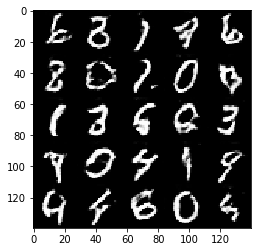

Epoch 2/2 - Batch 1000/1875:  Discriminator Loss: 0.7118... Generator Loss: 1.6672
Epoch 2/2 - Batch 1010/1875:  Discriminator Loss: 0.5965... Generator Loss: 1.7341
Epoch 2/2 - Batch 1020/1875:  Discriminator Loss: 0.5876... Generator Loss: 1.8067
Epoch 2/2 - Batch 1030/1875:  Discriminator Loss: 0.5288... Generator Loss: 2.0340
Epoch 2/2 - Batch 1040/1875:  Discriminator Loss: 0.5273... Generator Loss: 2.0207
Epoch 2/2 - Batch 1050/1875:  Discriminator Loss: 0.5610... Generator Loss: 1.8515
Epoch 2/2 - Batch 1060/1875:  Discriminator Loss: 0.6785... Generator Loss: 1.4395
Epoch 2/2 - Batch 1070/1875:  Discriminator Loss: 0.6280... Generator Loss: 1.5394
Epoch 2/2 - Batch 1080/1875:  Discriminator Loss: 0.9834... Generator Loss: 0.8526
Epoch 2/2 - Batch 1090/1875:  Discriminator Loss: 0.6420... Generator Loss: 1.5786


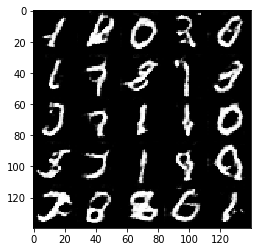

Epoch 2/2 - Batch 1100/1875:  Discriminator Loss: 0.6943... Generator Loss: 1.3862
Epoch 2/2 - Batch 1110/1875:  Discriminator Loss: 0.8225... Generator Loss: 2.9212
Epoch 2/2 - Batch 1120/1875:  Discriminator Loss: 0.5594... Generator Loss: 2.0268
Epoch 2/2 - Batch 1130/1875:  Discriminator Loss: 0.7228... Generator Loss: 1.3293
Epoch 2/2 - Batch 1140/1875:  Discriminator Loss: 0.5328... Generator Loss: 1.8712
Epoch 2/2 - Batch 1150/1875:  Discriminator Loss: 0.5347... Generator Loss: 2.4632
Epoch 2/2 - Batch 1160/1875:  Discriminator Loss: 1.4017... Generator Loss: 0.5644
Epoch 2/2 - Batch 1170/1875:  Discriminator Loss: 0.6376... Generator Loss: 1.7076
Epoch 2/2 - Batch 1180/1875:  Discriminator Loss: 0.6335... Generator Loss: 1.7230
Epoch 2/2 - Batch 1190/1875:  Discriminator Loss: 0.5609... Generator Loss: 1.8472


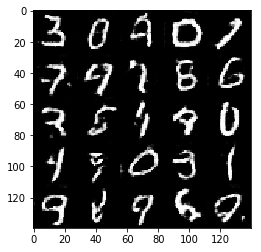

Epoch 2/2 - Batch 1200/1875:  Discriminator Loss: 1.6612... Generator Loss: 0.4396
Epoch 2/2 - Batch 1210/1875:  Discriminator Loss: 0.5695... Generator Loss: 1.8730
Epoch 2/2 - Batch 1220/1875:  Discriminator Loss: 0.7173... Generator Loss: 1.3508
Epoch 2/2 - Batch 1230/1875:  Discriminator Loss: 0.6483... Generator Loss: 1.6160
Epoch 2/2 - Batch 1240/1875:  Discriminator Loss: 0.7770... Generator Loss: 1.2144
Epoch 2/2 - Batch 1250/1875:  Discriminator Loss: 0.7669... Generator Loss: 1.2592
Epoch 2/2 - Batch 1260/1875:  Discriminator Loss: 0.7824... Generator Loss: 1.3008
Epoch 2/2 - Batch 1270/1875:  Discriminator Loss: 1.6219... Generator Loss: 4.1743
Epoch 2/2 - Batch 1280/1875:  Discriminator Loss: 0.5884... Generator Loss: 2.1246
Epoch 2/2 - Batch 1290/1875:  Discriminator Loss: 0.6295... Generator Loss: 1.6052


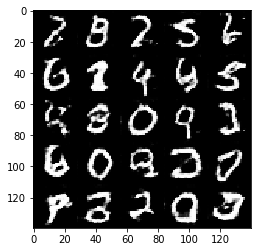

Epoch 2/2 - Batch 1300/1875:  Discriminator Loss: 0.6172... Generator Loss: 1.6678
Epoch 2/2 - Batch 1310/1875:  Discriminator Loss: 0.8132... Generator Loss: 1.1723
Epoch 2/2 - Batch 1320/1875:  Discriminator Loss: 0.7646... Generator Loss: 1.2738
Epoch 2/2 - Batch 1330/1875:  Discriminator Loss: 1.0225... Generator Loss: 0.8611
Epoch 2/2 - Batch 1340/1875:  Discriminator Loss: 0.8503... Generator Loss: 1.0536
Epoch 2/2 - Batch 1350/1875:  Discriminator Loss: 0.5879... Generator Loss: 1.8104
Epoch 2/2 - Batch 1360/1875:  Discriminator Loss: 0.7201... Generator Loss: 1.3976
Epoch 2/2 - Batch 1370/1875:  Discriminator Loss: 0.6791... Generator Loss: 1.3740
Epoch 2/2 - Batch 1380/1875:  Discriminator Loss: 0.4914... Generator Loss: 2.1783
Epoch 2/2 - Batch 1390/1875:  Discriminator Loss: 0.4864... Generator Loss: 2.4280


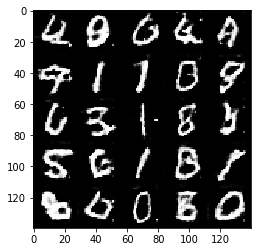

Epoch 2/2 - Batch 1400/1875:  Discriminator Loss: 0.8284... Generator Loss: 1.1226
Epoch 2/2 - Batch 1410/1875:  Discriminator Loss: 0.7778... Generator Loss: 1.2191
Epoch 2/2 - Batch 1420/1875:  Discriminator Loss: 0.4781... Generator Loss: 2.2904
Epoch 2/2 - Batch 1430/1875:  Discriminator Loss: 0.5844... Generator Loss: 1.7532
Epoch 2/2 - Batch 1440/1875:  Discriminator Loss: 0.7521... Generator Loss: 1.2028
Epoch 2/2 - Batch 1450/1875:  Discriminator Loss: 0.4975... Generator Loss: 2.2988
Epoch 2/2 - Batch 1460/1875:  Discriminator Loss: 0.7266... Generator Loss: 1.4755
Epoch 2/2 - Batch 1470/1875:  Discriminator Loss: 0.5302... Generator Loss: 1.9779
Epoch 2/2 - Batch 1480/1875:  Discriminator Loss: 0.9523... Generator Loss: 0.9637
Epoch 2/2 - Batch 1490/1875:  Discriminator Loss: 0.6715... Generator Loss: 1.4552


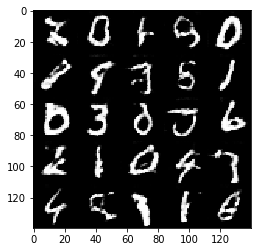

Epoch 2/2 - Batch 1500/1875:  Discriminator Loss: 0.5169... Generator Loss: 2.1878
Epoch 2/2 - Batch 1510/1875:  Discriminator Loss: 0.8059... Generator Loss: 1.1312
Epoch 2/2 - Batch 1520/1875:  Discriminator Loss: 1.6716... Generator Loss: 5.1266
Epoch 2/2 - Batch 1530/1875:  Discriminator Loss: 0.6594... Generator Loss: 1.5705
Epoch 2/2 - Batch 1540/1875:  Discriminator Loss: 0.5332... Generator Loss: 2.0105
Epoch 2/2 - Batch 1550/1875:  Discriminator Loss: 0.5151... Generator Loss: 2.3467
Epoch 2/2 - Batch 1560/1875:  Discriminator Loss: 0.5381... Generator Loss: 2.0150
Epoch 2/2 - Batch 1570/1875:  Discriminator Loss: 0.6069... Generator Loss: 1.6273
Epoch 2/2 - Batch 1580/1875:  Discriminator Loss: 0.5527... Generator Loss: 1.7896
Epoch 2/2 - Batch 1590/1875:  Discriminator Loss: 0.6912... Generator Loss: 1.4361


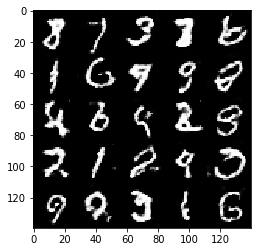

Epoch 2/2 - Batch 1600/1875:  Discriminator Loss: 0.7204... Generator Loss: 2.2756
Epoch 2/2 - Batch 1610/1875:  Discriminator Loss: 0.5492... Generator Loss: 1.9267
Epoch 2/2 - Batch 1620/1875:  Discriminator Loss: 0.7376... Generator Loss: 1.3024
Epoch 2/2 - Batch 1630/1875:  Discriminator Loss: 0.4471... Generator Loss: 2.5138
Epoch 2/2 - Batch 1640/1875:  Discriminator Loss: 0.5148... Generator Loss: 2.1136
Epoch 2/2 - Batch 1650/1875:  Discriminator Loss: 1.3927... Generator Loss: 0.6736
Epoch 2/2 - Batch 1660/1875:  Discriminator Loss: 0.8778... Generator Loss: 1.2507
Epoch 2/2 - Batch 1670/1875:  Discriminator Loss: 0.5948... Generator Loss: 1.9764
Epoch 2/2 - Batch 1680/1875:  Discriminator Loss: 1.0283... Generator Loss: 0.9908
Epoch 2/2 - Batch 1690/1875:  Discriminator Loss: 0.7302... Generator Loss: 1.3192


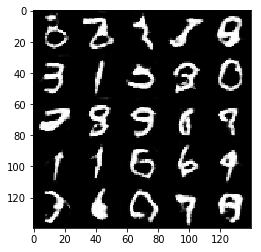

Epoch 2/2 - Batch 1700/1875:  Discriminator Loss: 0.8290... Generator Loss: 1.1540
Epoch 2/2 - Batch 1710/1875:  Discriminator Loss: 1.3491... Generator Loss: 0.6687
Epoch 2/2 - Batch 1720/1875:  Discriminator Loss: 0.5998... Generator Loss: 1.6714
Epoch 2/2 - Batch 1730/1875:  Discriminator Loss: 0.5710... Generator Loss: 1.8047
Epoch 2/2 - Batch 1740/1875:  Discriminator Loss: 0.4528... Generator Loss: 2.5468
Epoch 2/2 - Batch 1750/1875:  Discriminator Loss: 0.9064... Generator Loss: 1.0280
Epoch 2/2 - Batch 1760/1875:  Discriminator Loss: 0.6770... Generator Loss: 2.3309
Epoch 2/2 - Batch 1770/1875:  Discriminator Loss: 0.4295... Generator Loss: 2.7809
Epoch 2/2 - Batch 1780/1875:  Discriminator Loss: 0.5607... Generator Loss: 2.3587
Epoch 2/2 - Batch 1790/1875:  Discriminator Loss: 0.5759... Generator Loss: 1.8060


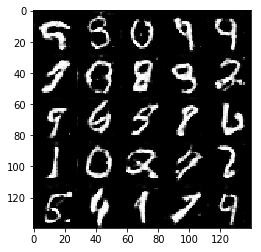

Epoch 2/2 - Batch 1800/1875:  Discriminator Loss: 0.5295... Generator Loss: 1.9743
Epoch 2/2 - Batch 1810/1875:  Discriminator Loss: 0.5867... Generator Loss: 2.1501
Epoch 2/2 - Batch 1820/1875:  Discriminator Loss: 0.6497... Generator Loss: 1.4730
Epoch 2/2 - Batch 1830/1875:  Discriminator Loss: 0.6436... Generator Loss: 1.4939
Epoch 2/2 - Batch 1840/1875:  Discriminator Loss: 0.4075... Generator Loss: 2.7608
Epoch 2/2 - Batch 1850/1875:  Discriminator Loss: 0.4695... Generator Loss: 2.2358
Epoch 2/2 - Batch 1860/1875:  Discriminator Loss: 0.6351... Generator Loss: 1.5386
Epoch 2/2 - Batch 1870/1875:  Discriminator Loss: 0.6680... Generator Loss: 1.4504


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/6331:  Discriminator Loss: 0.6268... Generator Loss: 1.6329
Epoch 1/1 - Batch 20/6331:  Discriminator Loss: 0.9533... Generator Loss: 0.9613
Epoch 1/1 - Batch 30/6331:  Discriminator Loss: 0.5857... Generator Loss: 1.7656
Epoch 1/1 - Batch 40/6331:  Discriminator Loss: 2.3406... Generator Loss: 0.2449
Epoch 1/1 - Batch 50/6331:  Discriminator Loss: 0.5279... Generator Loss: 6.3354
Epoch 1/1 - Batch 60/6331:  Discriminator Loss: 0.4104... Generator Loss: 3.9212
Epoch 1/1 - Batch 70/6331:  Discriminator Loss: 0.9548... Generator Loss: 0.9550
Epoch 1/1 - Batch 80/6331:  Discriminator Loss: 0.5930... Generator Loss: 3.3608
Epoch 1/1 - Batch 90/6331:  Discriminator Loss: 0.8532... Generator Loss: 1.2239


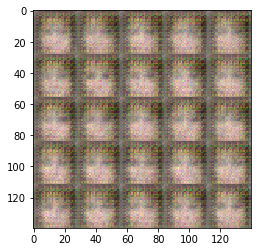

Epoch 1/1 - Batch 100/6331:  Discriminator Loss: 0.7661... Generator Loss: 1.2508
Epoch 1/1 - Batch 110/6331:  Discriminator Loss: 0.4757... Generator Loss: 2.5868
Epoch 1/1 - Batch 120/6331:  Discriminator Loss: 0.4092... Generator Loss: 3.6672
Epoch 1/1 - Batch 130/6331:  Discriminator Loss: 0.5679... Generator Loss: 2.0930
Epoch 1/1 - Batch 140/6331:  Discriminator Loss: 0.4935... Generator Loss: 2.3847
Epoch 1/1 - Batch 150/6331:  Discriminator Loss: 0.4976... Generator Loss: 2.2998
Epoch 1/1 - Batch 160/6331:  Discriminator Loss: 0.4365... Generator Loss: 2.8126
Epoch 1/1 - Batch 170/6331:  Discriminator Loss: 0.5245... Generator Loss: 2.4817
Epoch 1/1 - Batch 180/6331:  Discriminator Loss: 0.5931... Generator Loss: 3.0581
Epoch 1/1 - Batch 190/6331:  Discriminator Loss: 0.4894... Generator Loss: 2.7598


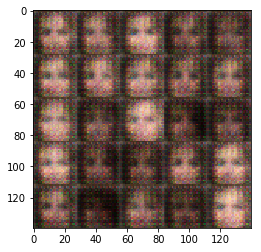

Epoch 1/1 - Batch 200/6331:  Discriminator Loss: 1.0908... Generator Loss: 4.4436
Epoch 1/1 - Batch 210/6331:  Discriminator Loss: 0.5803... Generator Loss: 2.4798
Epoch 1/1 - Batch 220/6331:  Discriminator Loss: 0.9176... Generator Loss: 4.6315
Epoch 1/1 - Batch 230/6331:  Discriminator Loss: 0.7420... Generator Loss: 1.2845
Epoch 1/1 - Batch 240/6331:  Discriminator Loss: 0.6543... Generator Loss: 1.6479
Epoch 1/1 - Batch 250/6331:  Discriminator Loss: 0.6031... Generator Loss: 1.7804
Epoch 1/1 - Batch 260/6331:  Discriminator Loss: 0.4691... Generator Loss: 3.6097
Epoch 1/1 - Batch 270/6331:  Discriminator Loss: 0.7520... Generator Loss: 1.5193
Epoch 1/1 - Batch 280/6331:  Discriminator Loss: 0.5548... Generator Loss: 2.8966
Epoch 1/1 - Batch 290/6331:  Discriminator Loss: 0.6284... Generator Loss: 1.8125


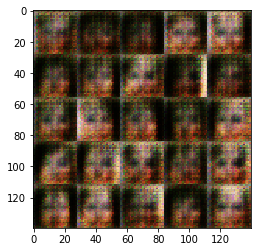

Epoch 1/1 - Batch 300/6331:  Discriminator Loss: 0.5244... Generator Loss: 2.7659
Epoch 1/1 - Batch 310/6331:  Discriminator Loss: 0.5412... Generator Loss: 2.4728
Epoch 1/1 - Batch 320/6331:  Discriminator Loss: 0.6267... Generator Loss: 2.0249
Epoch 1/1 - Batch 330/6331:  Discriminator Loss: 1.2841... Generator Loss: 0.6220
Epoch 1/1 - Batch 340/6331:  Discriminator Loss: 1.1994... Generator Loss: 4.2907
Epoch 1/1 - Batch 350/6331:  Discriminator Loss: 0.8391... Generator Loss: 1.2610
Epoch 1/1 - Batch 360/6331:  Discriminator Loss: 1.4768... Generator Loss: 0.5064
Epoch 1/1 - Batch 370/6331:  Discriminator Loss: 0.7586... Generator Loss: 1.4098
Epoch 1/1 - Batch 380/6331:  Discriminator Loss: 0.5702... Generator Loss: 2.2126
Epoch 1/1 - Batch 390/6331:  Discriminator Loss: 0.5919... Generator Loss: 2.5577


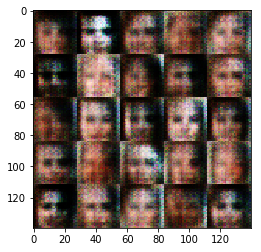

Epoch 1/1 - Batch 400/6331:  Discriminator Loss: 0.8027... Generator Loss: 1.1609
Epoch 1/1 - Batch 410/6331:  Discriminator Loss: 0.9011... Generator Loss: 1.2633
Epoch 1/1 - Batch 420/6331:  Discriminator Loss: 1.0683... Generator Loss: 1.0108
Epoch 1/1 - Batch 430/6331:  Discriminator Loss: 0.6758... Generator Loss: 1.6362
Epoch 1/1 - Batch 440/6331:  Discriminator Loss: 0.8069... Generator Loss: 1.2968
Epoch 1/1 - Batch 450/6331:  Discriminator Loss: 0.6234... Generator Loss: 1.7895
Epoch 1/1 - Batch 460/6331:  Discriminator Loss: 0.9047... Generator Loss: 1.1871
Epoch 1/1 - Batch 470/6331:  Discriminator Loss: 0.5085... Generator Loss: 2.8856
Epoch 1/1 - Batch 480/6331:  Discriminator Loss: 0.7326... Generator Loss: 1.4431
Epoch 1/1 - Batch 490/6331:  Discriminator Loss: 0.7345... Generator Loss: 1.3685


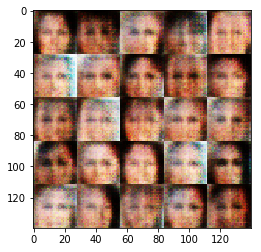

Epoch 1/1 - Batch 500/6331:  Discriminator Loss: 1.6785... Generator Loss: 0.4592
Epoch 1/1 - Batch 510/6331:  Discriminator Loss: 0.8383... Generator Loss: 1.1013
Epoch 1/1 - Batch 520/6331:  Discriminator Loss: 1.0605... Generator Loss: 0.8286
Epoch 1/1 - Batch 530/6331:  Discriminator Loss: 0.6463... Generator Loss: 1.6660
Epoch 1/1 - Batch 540/6331:  Discriminator Loss: 0.5968... Generator Loss: 2.0137
Epoch 1/1 - Batch 550/6331:  Discriminator Loss: 1.1384... Generator Loss: 0.7291
Epoch 1/1 - Batch 560/6331:  Discriminator Loss: 1.6438... Generator Loss: 0.4585
Epoch 1/1 - Batch 570/6331:  Discriminator Loss: 0.8497... Generator Loss: 1.2306
Epoch 1/1 - Batch 580/6331:  Discriminator Loss: 0.7588... Generator Loss: 1.4041
Epoch 1/1 - Batch 590/6331:  Discriminator Loss: 0.6250... Generator Loss: 1.6640


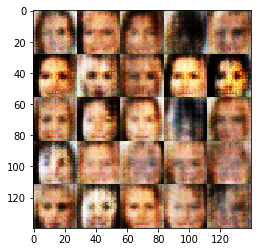

Epoch 1/1 - Batch 600/6331:  Discriminator Loss: 1.3364... Generator Loss: 0.6002
Epoch 1/1 - Batch 610/6331:  Discriminator Loss: 0.6270... Generator Loss: 1.7611
Epoch 1/1 - Batch 620/6331:  Discriminator Loss: 0.8728... Generator Loss: 2.5173
Epoch 1/1 - Batch 630/6331:  Discriminator Loss: 0.8751... Generator Loss: 1.8608
Epoch 1/1 - Batch 640/6331:  Discriminator Loss: 0.8183... Generator Loss: 2.0987
Epoch 1/1 - Batch 650/6331:  Discriminator Loss: 0.7236... Generator Loss: 2.5417
Epoch 1/1 - Batch 660/6331:  Discriminator Loss: 0.8472... Generator Loss: 2.6343
Epoch 1/1 - Batch 670/6331:  Discriminator Loss: 1.0748... Generator Loss: 0.8123
Epoch 1/1 - Batch 680/6331:  Discriminator Loss: 0.7504... Generator Loss: 1.6345
Epoch 1/1 - Batch 690/6331:  Discriminator Loss: 1.2589... Generator Loss: 4.7131


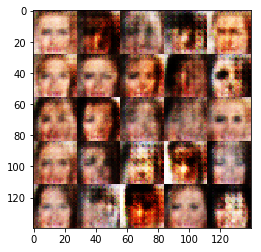

Epoch 1/1 - Batch 700/6331:  Discriminator Loss: 0.9475... Generator Loss: 1.0540
Epoch 1/1 - Batch 710/6331:  Discriminator Loss: 1.0067... Generator Loss: 1.0609
Epoch 1/1 - Batch 720/6331:  Discriminator Loss: 0.6617... Generator Loss: 2.1636
Epoch 1/1 - Batch 730/6331:  Discriminator Loss: 1.4557... Generator Loss: 0.5597
Epoch 1/1 - Batch 740/6331:  Discriminator Loss: 0.8182... Generator Loss: 2.0414
Epoch 1/1 - Batch 750/6331:  Discriminator Loss: 0.6777... Generator Loss: 1.7780
Epoch 1/1 - Batch 760/6331:  Discriminator Loss: 0.7369... Generator Loss: 1.6257
Epoch 1/1 - Batch 770/6331:  Discriminator Loss: 0.7951... Generator Loss: 2.6616
Epoch 1/1 - Batch 780/6331:  Discriminator Loss: 0.7636... Generator Loss: 2.0815
Epoch 1/1 - Batch 790/6331:  Discriminator Loss: 0.7461... Generator Loss: 2.1898


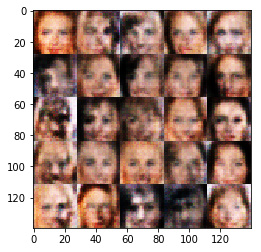

Epoch 1/1 - Batch 800/6331:  Discriminator Loss: 0.8328... Generator Loss: 1.4722
Epoch 1/1 - Batch 810/6331:  Discriminator Loss: 1.2693... Generator Loss: 0.6882
Epoch 1/1 - Batch 820/6331:  Discriminator Loss: 0.9642... Generator Loss: 3.0186
Epoch 1/1 - Batch 830/6331:  Discriminator Loss: 0.7344... Generator Loss: 2.3310
Epoch 1/1 - Batch 840/6331:  Discriminator Loss: 1.2203... Generator Loss: 0.6059
Epoch 1/1 - Batch 850/6331:  Discriminator Loss: 1.1054... Generator Loss: 0.7626
Epoch 1/1 - Batch 860/6331:  Discriminator Loss: 0.7281... Generator Loss: 1.6232
Epoch 1/1 - Batch 870/6331:  Discriminator Loss: 0.6939... Generator Loss: 1.9787
Epoch 1/1 - Batch 880/6331:  Discriminator Loss: 1.4610... Generator Loss: 4.4407
Epoch 1/1 - Batch 890/6331:  Discriminator Loss: 0.7996... Generator Loss: 1.4428


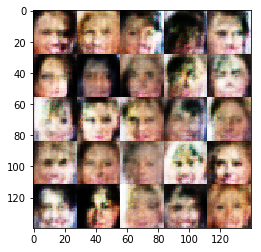

Epoch 1/1 - Batch 900/6331:  Discriminator Loss: 0.9582... Generator Loss: 2.3352
Epoch 1/1 - Batch 910/6331:  Discriminator Loss: 0.8763... Generator Loss: 2.2788
Epoch 1/1 - Batch 920/6331:  Discriminator Loss: 0.9271... Generator Loss: 1.3690
Epoch 1/1 - Batch 930/6331:  Discriminator Loss: 0.8694... Generator Loss: 2.0169
Epoch 1/1 - Batch 940/6331:  Discriminator Loss: 0.7358... Generator Loss: 1.7715
Epoch 1/1 - Batch 950/6331:  Discriminator Loss: 0.8202... Generator Loss: 1.3445
Epoch 1/1 - Batch 960/6331:  Discriminator Loss: 0.7732... Generator Loss: 1.4609
Epoch 1/1 - Batch 970/6331:  Discriminator Loss: 0.9533... Generator Loss: 0.9484
Epoch 1/1 - Batch 980/6331:  Discriminator Loss: 0.8191... Generator Loss: 2.1437
Epoch 1/1 - Batch 990/6331:  Discriminator Loss: 0.7737... Generator Loss: 1.4134


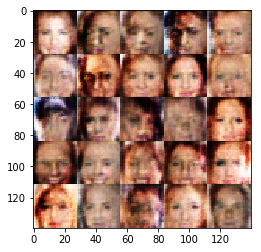

Epoch 1/1 - Batch 1000/6331:  Discriminator Loss: 0.7199... Generator Loss: 1.7801
Epoch 1/1 - Batch 1010/6331:  Discriminator Loss: 0.9781... Generator Loss: 1.2303
Epoch 1/1 - Batch 1020/6331:  Discriminator Loss: 0.9295... Generator Loss: 1.0608
Epoch 1/1 - Batch 1030/6331:  Discriminator Loss: 0.8347... Generator Loss: 1.3409
Epoch 1/1 - Batch 1040/6331:  Discriminator Loss: 1.4664... Generator Loss: 0.5163
Epoch 1/1 - Batch 1050/6331:  Discriminator Loss: 0.9633... Generator Loss: 0.9002
Epoch 1/1 - Batch 1060/6331:  Discriminator Loss: 0.8351... Generator Loss: 1.6972
Epoch 1/1 - Batch 1070/6331:  Discriminator Loss: 0.7839... Generator Loss: 1.7151
Epoch 1/1 - Batch 1080/6331:  Discriminator Loss: 0.9945... Generator Loss: 0.8968
Epoch 1/1 - Batch 1090/6331:  Discriminator Loss: 0.7909... Generator Loss: 1.2112


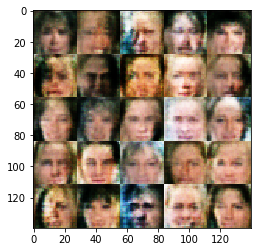

Epoch 1/1 - Batch 1100/6331:  Discriminator Loss: 1.2622... Generator Loss: 0.5860
Epoch 1/1 - Batch 1110/6331:  Discriminator Loss: 0.9641... Generator Loss: 1.0253
Epoch 1/1 - Batch 1120/6331:  Discriminator Loss: 0.7663... Generator Loss: 1.9193
Epoch 1/1 - Batch 1130/6331:  Discriminator Loss: 0.7760... Generator Loss: 1.5952
Epoch 1/1 - Batch 1140/6331:  Discriminator Loss: 0.7483... Generator Loss: 1.4589
Epoch 1/1 - Batch 1150/6331:  Discriminator Loss: 0.8336... Generator Loss: 2.5889
Epoch 1/1 - Batch 1160/6331:  Discriminator Loss: 0.9768... Generator Loss: 0.8916
Epoch 1/1 - Batch 1170/6331:  Discriminator Loss: 0.7544... Generator Loss: 1.5179
Epoch 1/1 - Batch 1180/6331:  Discriminator Loss: 0.7954... Generator Loss: 1.8580
Epoch 1/1 - Batch 1190/6331:  Discriminator Loss: 0.8149... Generator Loss: 2.3460


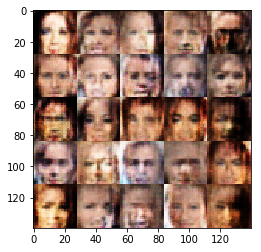

Epoch 1/1 - Batch 1200/6331:  Discriminator Loss: 0.8788... Generator Loss: 2.5506
Epoch 1/1 - Batch 1210/6331:  Discriminator Loss: 1.1783... Generator Loss: 0.6681
Epoch 1/1 - Batch 1220/6331:  Discriminator Loss: 0.9733... Generator Loss: 0.9599
Epoch 1/1 - Batch 1230/6331:  Discriminator Loss: 0.8699... Generator Loss: 1.0726
Epoch 1/1 - Batch 1240/6331:  Discriminator Loss: 0.7566... Generator Loss: 1.7994
Epoch 1/1 - Batch 1250/6331:  Discriminator Loss: 0.8584... Generator Loss: 1.3806
Epoch 1/1 - Batch 1260/6331:  Discriminator Loss: 1.2022... Generator Loss: 0.6199
Epoch 1/1 - Batch 1270/6331:  Discriminator Loss: 0.8033... Generator Loss: 1.2632
Epoch 1/1 - Batch 1280/6331:  Discriminator Loss: 1.1073... Generator Loss: 2.8522
Epoch 1/1 - Batch 1290/6331:  Discriminator Loss: 0.8867... Generator Loss: 0.9728


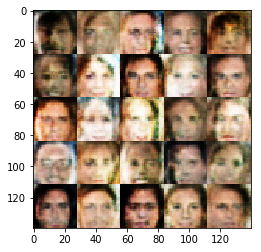

Epoch 1/1 - Batch 1300/6331:  Discriminator Loss: 0.8891... Generator Loss: 1.3659
Epoch 1/1 - Batch 1310/6331:  Discriminator Loss: 1.4067... Generator Loss: 0.4818
Epoch 1/1 - Batch 1320/6331:  Discriminator Loss: 0.8417... Generator Loss: 1.2077
Epoch 1/1 - Batch 1330/6331:  Discriminator Loss: 0.9238... Generator Loss: 0.9059
Epoch 1/1 - Batch 1340/6331:  Discriminator Loss: 1.0345... Generator Loss: 2.3495
Epoch 1/1 - Batch 1350/6331:  Discriminator Loss: 0.7472... Generator Loss: 1.3532
Epoch 1/1 - Batch 1360/6331:  Discriminator Loss: 0.8189... Generator Loss: 1.9619
Epoch 1/1 - Batch 1370/6331:  Discriminator Loss: 1.0178... Generator Loss: 0.8688
Epoch 1/1 - Batch 1380/6331:  Discriminator Loss: 1.4020... Generator Loss: 0.4858
Epoch 1/1 - Batch 1390/6331:  Discriminator Loss: 1.0101... Generator Loss: 0.9904


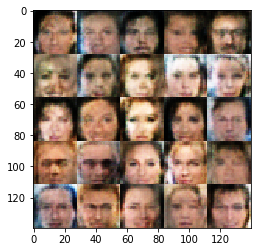

Epoch 1/1 - Batch 1400/6331:  Discriminator Loss: 1.0175... Generator Loss: 0.8201
Epoch 1/1 - Batch 1410/6331:  Discriminator Loss: 1.0930... Generator Loss: 0.7737
Epoch 1/1 - Batch 1420/6331:  Discriminator Loss: 0.8587... Generator Loss: 1.2992
Epoch 1/1 - Batch 1430/6331:  Discriminator Loss: 0.8180... Generator Loss: 1.6041
Epoch 1/1 - Batch 1440/6331:  Discriminator Loss: 0.8439... Generator Loss: 1.4730
Epoch 1/1 - Batch 1450/6331:  Discriminator Loss: 1.1146... Generator Loss: 0.7476
Epoch 1/1 - Batch 1460/6331:  Discriminator Loss: 0.9068... Generator Loss: 1.4919
Epoch 1/1 - Batch 1470/6331:  Discriminator Loss: 0.7087... Generator Loss: 2.0618
Epoch 1/1 - Batch 1480/6331:  Discriminator Loss: 0.7746... Generator Loss: 1.7594
Epoch 1/1 - Batch 1490/6331:  Discriminator Loss: 0.8422... Generator Loss: 1.1705


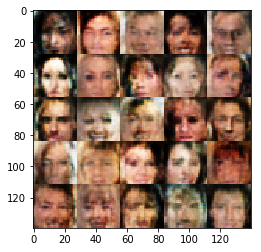

Epoch 1/1 - Batch 1500/6331:  Discriminator Loss: 0.8727... Generator Loss: 1.0948
Epoch 1/1 - Batch 1510/6331:  Discriminator Loss: 0.9376... Generator Loss: 1.0301
Epoch 1/1 - Batch 1520/6331:  Discriminator Loss: 0.8593... Generator Loss: 1.5431
Epoch 1/1 - Batch 1530/6331:  Discriminator Loss: 0.9156... Generator Loss: 2.0809
Epoch 1/1 - Batch 1540/6331:  Discriminator Loss: 0.9636... Generator Loss: 0.8515
Epoch 1/1 - Batch 1550/6331:  Discriminator Loss: 0.9426... Generator Loss: 1.4320
Epoch 1/1 - Batch 1560/6331:  Discriminator Loss: 0.7066... Generator Loss: 1.5111
Epoch 1/1 - Batch 1570/6331:  Discriminator Loss: 1.0426... Generator Loss: 0.7791
Epoch 1/1 - Batch 1580/6331:  Discriminator Loss: 1.0387... Generator Loss: 0.8296
Epoch 1/1 - Batch 1590/6331:  Discriminator Loss: 0.8495... Generator Loss: 1.3856


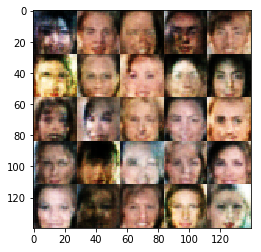

Epoch 1/1 - Batch 1600/6331:  Discriminator Loss: 1.1984... Generator Loss: 0.6207
Epoch 1/1 - Batch 1610/6331:  Discriminator Loss: 0.9884... Generator Loss: 0.8611
Epoch 1/1 - Batch 1620/6331:  Discriminator Loss: 0.9368... Generator Loss: 0.9992
Epoch 1/1 - Batch 1630/6331:  Discriminator Loss: 1.4280... Generator Loss: 0.4979
Epoch 1/1 - Batch 1640/6331:  Discriminator Loss: 0.9129... Generator Loss: 1.2176
Epoch 1/1 - Batch 1650/6331:  Discriminator Loss: 0.9773... Generator Loss: 0.8443
Epoch 1/1 - Batch 1660/6331:  Discriminator Loss: 0.7782... Generator Loss: 1.9325
Epoch 1/1 - Batch 1670/6331:  Discriminator Loss: 0.9774... Generator Loss: 1.8730
Epoch 1/1 - Batch 1680/6331:  Discriminator Loss: 0.6764... Generator Loss: 1.6209
Epoch 1/1 - Batch 1690/6331:  Discriminator Loss: 0.9012... Generator Loss: 1.1411


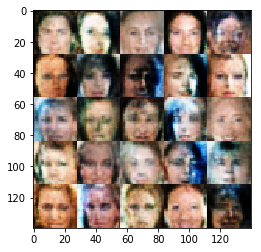

Epoch 1/1 - Batch 1700/6331:  Discriminator Loss: 1.5007... Generator Loss: 0.4344
Epoch 1/1 - Batch 1710/6331:  Discriminator Loss: 0.8965... Generator Loss: 1.0667
Epoch 1/1 - Batch 1720/6331:  Discriminator Loss: 1.0638... Generator Loss: 0.7314
Epoch 1/1 - Batch 1730/6331:  Discriminator Loss: 1.0025... Generator Loss: 0.9115
Epoch 1/1 - Batch 1740/6331:  Discriminator Loss: 1.0366... Generator Loss: 0.8165
Epoch 1/1 - Batch 1750/6331:  Discriminator Loss: 0.7492... Generator Loss: 1.5112
Epoch 1/1 - Batch 1760/6331:  Discriminator Loss: 0.8880... Generator Loss: 1.0523
Epoch 1/1 - Batch 1770/6331:  Discriminator Loss: 0.8475... Generator Loss: 1.1978
Epoch 1/1 - Batch 1780/6331:  Discriminator Loss: 1.2219... Generator Loss: 0.5968
Epoch 1/1 - Batch 1790/6331:  Discriminator Loss: 0.7078... Generator Loss: 1.5593


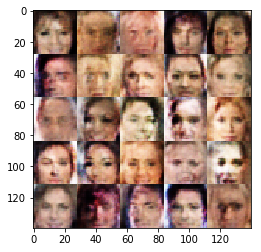

Epoch 1/1 - Batch 1800/6331:  Discriminator Loss: 1.3059... Generator Loss: 0.5350
Epoch 1/1 - Batch 1810/6331:  Discriminator Loss: 0.8448... Generator Loss: 1.1767
Epoch 1/1 - Batch 1820/6331:  Discriminator Loss: 0.9957... Generator Loss: 2.1759
Epoch 1/1 - Batch 1830/6331:  Discriminator Loss: 0.7964... Generator Loss: 1.6035
Epoch 1/1 - Batch 1840/6331:  Discriminator Loss: 0.8842... Generator Loss: 0.9879
Epoch 1/1 - Batch 1850/6331:  Discriminator Loss: 1.1625... Generator Loss: 0.6494
Epoch 1/1 - Batch 1860/6331:  Discriminator Loss: 0.8435... Generator Loss: 1.4584
Epoch 1/1 - Batch 1870/6331:  Discriminator Loss: 0.8903... Generator Loss: 1.2822
Epoch 1/1 - Batch 1880/6331:  Discriminator Loss: 1.1250... Generator Loss: 0.7237
Epoch 1/1 - Batch 1890/6331:  Discriminator Loss: 0.7745... Generator Loss: 1.2749


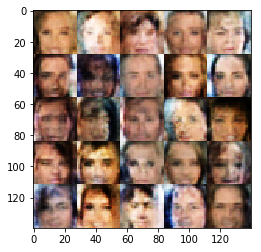

Epoch 1/1 - Batch 1900/6331:  Discriminator Loss: 1.2045... Generator Loss: 0.6342
Epoch 1/1 - Batch 1910/6331:  Discriminator Loss: 0.8334... Generator Loss: 1.7753
Epoch 1/1 - Batch 1920/6331:  Discriminator Loss: 1.0028... Generator Loss: 1.7112
Epoch 1/1 - Batch 1930/6331:  Discriminator Loss: 0.8415... Generator Loss: 1.3622
Epoch 1/1 - Batch 1940/6331:  Discriminator Loss: 1.1243... Generator Loss: 0.6871
Epoch 1/1 - Batch 1950/6331:  Discriminator Loss: 0.8615... Generator Loss: 1.2474
Epoch 1/1 - Batch 1960/6331:  Discriminator Loss: 1.2367... Generator Loss: 0.5959
Epoch 1/1 - Batch 1970/6331:  Discriminator Loss: 0.6206... Generator Loss: 1.9096
Epoch 1/1 - Batch 1980/6331:  Discriminator Loss: 0.6856... Generator Loss: 1.6399
Epoch 1/1 - Batch 1990/6331:  Discriminator Loss: 1.0148... Generator Loss: 0.8264


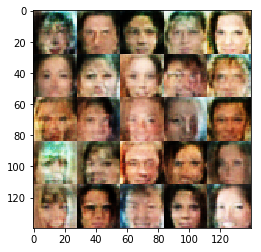

Epoch 1/1 - Batch 2000/6331:  Discriminator Loss: 0.8587... Generator Loss: 1.9121
Epoch 1/1 - Batch 2010/6331:  Discriminator Loss: 1.1126... Generator Loss: 2.3257
Epoch 1/1 - Batch 2020/6331:  Discriminator Loss: 1.1047... Generator Loss: 0.8395
Epoch 1/1 - Batch 2030/6331:  Discriminator Loss: 1.0491... Generator Loss: 0.8256
Epoch 1/1 - Batch 2040/6331:  Discriminator Loss: 0.8587... Generator Loss: 1.7316
Epoch 1/1 - Batch 2050/6331:  Discriminator Loss: 0.9014... Generator Loss: 1.0720
Epoch 1/1 - Batch 2060/6331:  Discriminator Loss: 1.0618... Generator Loss: 0.7951
Epoch 1/1 - Batch 2070/6331:  Discriminator Loss: 0.7923... Generator Loss: 1.5676
Epoch 1/1 - Batch 2080/6331:  Discriminator Loss: 0.7754... Generator Loss: 1.3302
Epoch 1/1 - Batch 2090/6331:  Discriminator Loss: 0.9154... Generator Loss: 0.9197


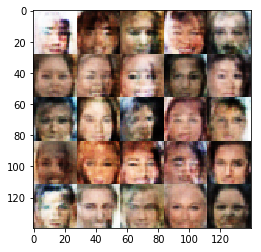

Epoch 1/1 - Batch 2100/6331:  Discriminator Loss: 0.7609... Generator Loss: 2.5355
Epoch 1/1 - Batch 2110/6331:  Discriminator Loss: 0.8813... Generator Loss: 1.0482
Epoch 1/1 - Batch 2120/6331:  Discriminator Loss: 1.0532... Generator Loss: 0.7945
Epoch 1/1 - Batch 2130/6331:  Discriminator Loss: 0.8644... Generator Loss: 1.3149
Epoch 1/1 - Batch 2140/6331:  Discriminator Loss: 0.6933... Generator Loss: 1.5451
Epoch 1/1 - Batch 2150/6331:  Discriminator Loss: 0.9141... Generator Loss: 0.9795
Epoch 1/1 - Batch 2160/6331:  Discriminator Loss: 0.7906... Generator Loss: 1.1748
Epoch 1/1 - Batch 2170/6331:  Discriminator Loss: 1.0527... Generator Loss: 0.7697
Epoch 1/1 - Batch 2180/6331:  Discriminator Loss: 0.8403... Generator Loss: 2.1481
Epoch 1/1 - Batch 2190/6331:  Discriminator Loss: 0.7579... Generator Loss: 2.3092


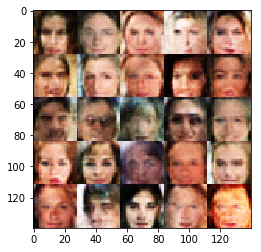

Epoch 1/1 - Batch 2200/6331:  Discriminator Loss: 0.8660... Generator Loss: 1.8669
Epoch 1/1 - Batch 2210/6331:  Discriminator Loss: 0.7640... Generator Loss: 1.7064
Epoch 1/1 - Batch 2220/6331:  Discriminator Loss: 0.6956... Generator Loss: 1.7063
Epoch 1/1 - Batch 2230/6331:  Discriminator Loss: 0.7051... Generator Loss: 2.1725
Epoch 1/1 - Batch 2240/6331:  Discriminator Loss: 0.7957... Generator Loss: 1.2061
Epoch 1/1 - Batch 2250/6331:  Discriminator Loss: 0.7598... Generator Loss: 1.3704
Epoch 1/1 - Batch 2260/6331:  Discriminator Loss: 0.7436... Generator Loss: 1.3082
Epoch 1/1 - Batch 2270/6331:  Discriminator Loss: 0.7041... Generator Loss: 1.6040
Epoch 1/1 - Batch 2280/6331:  Discriminator Loss: 1.1406... Generator Loss: 0.6777
Epoch 1/1 - Batch 2290/6331:  Discriminator Loss: 0.8470... Generator Loss: 2.5850


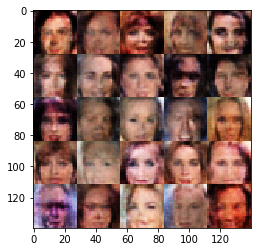

Epoch 1/1 - Batch 2300/6331:  Discriminator Loss: 0.7731... Generator Loss: 2.0017
Epoch 1/1 - Batch 2310/6331:  Discriminator Loss: 0.7823... Generator Loss: 1.2417
Epoch 1/1 - Batch 2320/6331:  Discriminator Loss: 0.9464... Generator Loss: 0.8937
Epoch 1/1 - Batch 2330/6331:  Discriminator Loss: 0.7710... Generator Loss: 1.2594
Epoch 1/1 - Batch 2340/6331:  Discriminator Loss: 0.9470... Generator Loss: 0.8744
Epoch 1/1 - Batch 2350/6331:  Discriminator Loss: 0.7680... Generator Loss: 1.4782
Epoch 1/1 - Batch 2360/6331:  Discriminator Loss: 1.0594... Generator Loss: 0.8784
Epoch 1/1 - Batch 2370/6331:  Discriminator Loss: 0.6560... Generator Loss: 1.6457
Epoch 1/1 - Batch 2380/6331:  Discriminator Loss: 1.4045... Generator Loss: 0.4915
Epoch 1/1 - Batch 2390/6331:  Discriminator Loss: 0.6478... Generator Loss: 1.7723


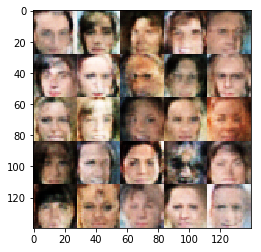

Epoch 1/1 - Batch 2400/6331:  Discriminator Loss: 0.8015... Generator Loss: 1.3067
Epoch 1/1 - Batch 2410/6331:  Discriminator Loss: 1.2837... Generator Loss: 0.5527
Epoch 1/1 - Batch 2420/6331:  Discriminator Loss: 1.0566... Generator Loss: 0.7761
Epoch 1/1 - Batch 2430/6331:  Discriminator Loss: 0.8566... Generator Loss: 1.3464
Epoch 1/1 - Batch 2440/6331:  Discriminator Loss: 1.1792... Generator Loss: 0.6270
Epoch 1/1 - Batch 2450/6331:  Discriminator Loss: 0.9026... Generator Loss: 0.9522
Epoch 1/1 - Batch 2460/6331:  Discriminator Loss: 0.8004... Generator Loss: 1.9945
Epoch 1/1 - Batch 2470/6331:  Discriminator Loss: 0.9657... Generator Loss: 0.8905
Epoch 1/1 - Batch 2480/6331:  Discriminator Loss: 0.8960... Generator Loss: 0.9893
Epoch 1/1 - Batch 2490/6331:  Discriminator Loss: 0.6772... Generator Loss: 2.1352


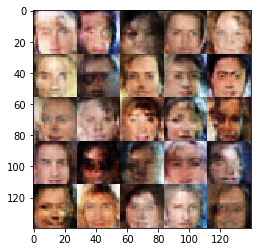

Epoch 1/1 - Batch 2500/6331:  Discriminator Loss: 0.7457... Generator Loss: 1.8796
Epoch 1/1 - Batch 2510/6331:  Discriminator Loss: 0.7213... Generator Loss: 1.7114
Epoch 1/1 - Batch 2520/6331:  Discriminator Loss: 0.8325... Generator Loss: 1.1373
Epoch 1/1 - Batch 2530/6331:  Discriminator Loss: 0.6783... Generator Loss: 1.7098
Epoch 1/1 - Batch 2540/6331:  Discriminator Loss: 0.8438... Generator Loss: 1.0684
Epoch 1/1 - Batch 2550/6331:  Discriminator Loss: 0.8816... Generator Loss: 1.0454
Epoch 1/1 - Batch 2560/6331:  Discriminator Loss: 0.6575... Generator Loss: 1.6711
Epoch 1/1 - Batch 2570/6331:  Discriminator Loss: 0.9495... Generator Loss: 0.8859
Epoch 1/1 - Batch 2580/6331:  Discriminator Loss: 0.7821... Generator Loss: 1.2959
Epoch 1/1 - Batch 2590/6331:  Discriminator Loss: 0.9791... Generator Loss: 0.8913


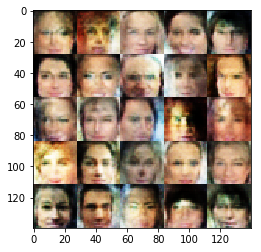

Epoch 1/1 - Batch 2600/6331:  Discriminator Loss: 0.8484... Generator Loss: 1.0879
Epoch 1/1 - Batch 2610/6331:  Discriminator Loss: 0.7613... Generator Loss: 1.1882
Epoch 1/1 - Batch 2620/6331:  Discriminator Loss: 0.7199... Generator Loss: 1.8964
Epoch 1/1 - Batch 2630/6331:  Discriminator Loss: 0.7758... Generator Loss: 1.6112
Epoch 1/1 - Batch 2640/6331:  Discriminator Loss: 0.7432... Generator Loss: 1.5854
Epoch 1/1 - Batch 2650/6331:  Discriminator Loss: 1.3138... Generator Loss: 0.5535
Epoch 1/1 - Batch 2660/6331:  Discriminator Loss: 0.6438... Generator Loss: 1.5109
Epoch 1/1 - Batch 2670/6331:  Discriminator Loss: 1.2243... Generator Loss: 0.5957
Epoch 1/1 - Batch 2680/6331:  Discriminator Loss: 0.9457... Generator Loss: 0.9286
Epoch 1/1 - Batch 2690/6331:  Discriminator Loss: 0.7763... Generator Loss: 1.3095


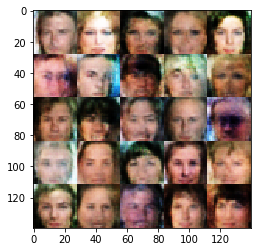

Epoch 1/1 - Batch 2700/6331:  Discriminator Loss: 0.9411... Generator Loss: 1.1022
Epoch 1/1 - Batch 2710/6331:  Discriminator Loss: 0.7907... Generator Loss: 1.2317
Epoch 1/1 - Batch 2720/6331:  Discriminator Loss: 0.9209... Generator Loss: 0.9496
Epoch 1/1 - Batch 2730/6331:  Discriminator Loss: 0.7635... Generator Loss: 1.6103
Epoch 1/1 - Batch 2740/6331:  Discriminator Loss: 0.7836... Generator Loss: 1.2232
Epoch 1/1 - Batch 2750/6331:  Discriminator Loss: 0.7245... Generator Loss: 1.6568
Epoch 1/1 - Batch 2760/6331:  Discriminator Loss: 1.1247... Generator Loss: 0.7367
Epoch 1/1 - Batch 2770/6331:  Discriminator Loss: 0.7826... Generator Loss: 1.4384
Epoch 1/1 - Batch 2780/6331:  Discriminator Loss: 0.8600... Generator Loss: 1.5087
Epoch 1/1 - Batch 2790/6331:  Discriminator Loss: 0.5716... Generator Loss: 2.0352


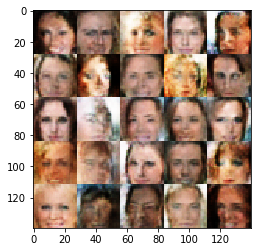

Epoch 1/1 - Batch 2800/6331:  Discriminator Loss: 0.6721... Generator Loss: 1.9340
Epoch 1/1 - Batch 2810/6331:  Discriminator Loss: 0.9632... Generator Loss: 1.8855
Epoch 1/1 - Batch 2820/6331:  Discriminator Loss: 0.8057... Generator Loss: 2.4146
Epoch 1/1 - Batch 2830/6331:  Discriminator Loss: 0.8071... Generator Loss: 2.2250
Epoch 1/1 - Batch 5940/6331:  Discriminator Loss: 1.3277... Generator Loss: 0.5912
Epoch 1/1 - Batch 5950/6331:  Discriminator Loss: 0.8912... Generator Loss: 0.9719
Epoch 1/1 - Batch 5960/6331:  Discriminator Loss: 0.8219... Generator Loss: 1.1204
Epoch 1/1 - Batch 5970/6331:  Discriminator Loss: 0.8294... Generator Loss: 1.1476
Epoch 1/1 - Batch 5980/6331:  Discriminator Loss: 1.0915... Generator Loss: 0.7117
Epoch 1/1 - Batch 5990/6331:  Discriminator Loss: 1.2954... Generator Loss: 2.1637


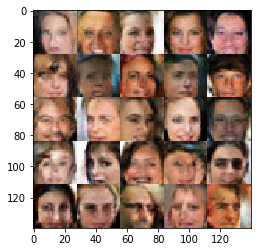

Epoch 1/1 - Batch 6000/6331:  Discriminator Loss: 0.6518... Generator Loss: 2.0424
Epoch 1/1 - Batch 6010/6331:  Discriminator Loss: 0.9497... Generator Loss: 0.9186
Epoch 1/1 - Batch 6020/6331:  Discriminator Loss: 0.9919... Generator Loss: 0.8568
Epoch 1/1 - Batch 6030/6331:  Discriminator Loss: 0.8071... Generator Loss: 1.3246
Epoch 1/1 - Batch 6040/6331:  Discriminator Loss: 0.7020... Generator Loss: 1.6503
Epoch 1/1 - Batch 6050/6331:  Discriminator Loss: 0.9464... Generator Loss: 1.0185
Epoch 1/1 - Batch 6060/6331:  Discriminator Loss: 1.0606... Generator Loss: 3.1964
Epoch 1/1 - Batch 6070/6331:  Discriminator Loss: 0.9350... Generator Loss: 1.0929
Epoch 1/1 - Batch 6080/6331:  Discriminator Loss: 0.7711... Generator Loss: 1.3363
Epoch 1/1 - Batch 6090/6331:  Discriminator Loss: 0.7458... Generator Loss: 1.3827


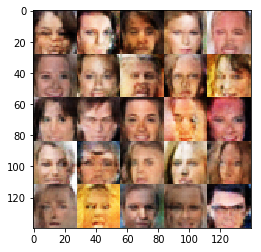

Epoch 1/1 - Batch 6100/6331:  Discriminator Loss: 0.9922... Generator Loss: 0.9219
Epoch 1/1 - Batch 6110/6331:  Discriminator Loss: 0.6820... Generator Loss: 1.4102
Epoch 1/1 - Batch 6120/6331:  Discriminator Loss: 0.9423... Generator Loss: 0.9656
Epoch 1/1 - Batch 6130/6331:  Discriminator Loss: 0.9709... Generator Loss: 2.2072
Epoch 1/1 - Batch 6140/6331:  Discriminator Loss: 1.0922... Generator Loss: 2.9867
Epoch 1/1 - Batch 6150/6331:  Discriminator Loss: 0.8180... Generator Loss: 1.8022
Epoch 1/1 - Batch 6160/6331:  Discriminator Loss: 0.9832... Generator Loss: 0.8472
Epoch 1/1 - Batch 6170/6331:  Discriminator Loss: 0.9679... Generator Loss: 0.9501
Epoch 1/1 - Batch 6180/6331:  Discriminator Loss: 0.7798... Generator Loss: 1.4145
Epoch 1/1 - Batch 6190/6331:  Discriminator Loss: 0.8683... Generator Loss: 1.1357


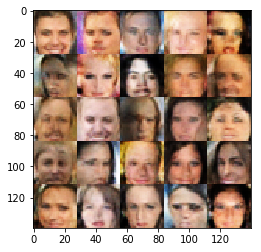

Epoch 1/1 - Batch 6200/6331:  Discriminator Loss: 1.3150... Generator Loss: 0.5297
Epoch 1/1 - Batch 6210/6331:  Discriminator Loss: 0.9281... Generator Loss: 1.0443
Epoch 1/1 - Batch 6220/6331:  Discriminator Loss: 0.8121... Generator Loss: 1.2328
Epoch 1/1 - Batch 6230/6331:  Discriminator Loss: 0.9288... Generator Loss: 0.9676
Epoch 1/1 - Batch 6240/6331:  Discriminator Loss: 0.6310... Generator Loss: 1.8701
Epoch 1/1 - Batch 6250/6331:  Discriminator Loss: 1.0504... Generator Loss: 0.7396
Epoch 1/1 - Batch 6260/6331:  Discriminator Loss: 0.7549... Generator Loss: 1.3498
Epoch 1/1 - Batch 6270/6331:  Discriminator Loss: 1.1837... Generator Loss: 0.6398
Epoch 1/1 - Batch 6280/6331:  Discriminator Loss: 0.7051... Generator Loss: 1.5308
Epoch 1/1 - Batch 6290/6331:  Discriminator Loss: 0.7438... Generator Loss: 1.5967


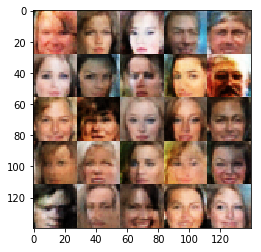

Epoch 1/1 - Batch 6300/6331:  Discriminator Loss: 1.0656... Generator Loss: 0.7632
Epoch 1/1 - Batch 6310/6331:  Discriminator Loss: 0.9510... Generator Loss: 0.9561
Epoch 1/1 - Batch 6320/6331:  Discriminator Loss: 1.1357... Generator Loss: 0.6855
Epoch 1/1 - Batch 6330/6331:  Discriminator Loss: 0.7430... Generator Loss: 1.3696


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.